In [5]:
import sys, os

# import python modules
from collections import Counter
import pickle
# import general data science modules 
from scipy import interpolate
import numpy as np
import pandas as pd

# import plot modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import sklearn modules
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# import project specific modules
import h5py

## Function Definitions

In [2]:
def subtract_background(data,feature_grid,fit_range=(7600,7700)):
    '''
    Fit the pre-edge data to a line with slope, and subtract slope info from data.
    
    Parameters:
    ----------
    data: array of shape (N_sample,N_features).
    feature_grid: 1-D array of shape (N_features,) corresponding feature grid for the data.
    fit_range: tuple of value (a,b), the left and right boundary of the data range of which data is fitted.
    
    Return:
    ------
    The data of same shape but with slope information subtracted.
    '''
    l = LinearRegression()
    
    
    energy_select = (feature_grid>=fit_range[0]) & (feature_grid<=fit_range[1])
    energy_to_fit = feature_grid[energy_select].reshape(-1,1)
    feature_grid = feature_grid.reshape(-1,1)
    
    data_to_fit = data[:,energy_select]

    data_subtrated = np.zeros_like(data)    
    for i,d in enumerate(data_to_fit):
        reg = l.fit(energy_to_fit, d)
        background = reg.predict(feature_grid)
        data_subtrated[i] = data[i] - background

    return data_subtrated
    
    
def normalize(data:tuple,grid:np.array=None,mean_range:list=None,keys:list=None,use_std:bool=True,use_derivative:bool=False):
    '''
    Normalize data: x -> (x-m)/v where m is the mean along axis=0, v is the std along axis=0.
    Parameters:
    ----------
    data: Input data of shape (N_samples,N_features)
    grid: Energy grid of shape(N_features,)
    mean_range: list of value [x,y] with x/y being the left/right boundary of the range
    use_std: boolean, whether 
    Return:
    The normalized data with NaN excluded.
    '''
    trans, fluos = data
    
    # calculate mean value for a given energy range
    if mean_range==None:
        mean_select = np.ones(fluos.shape[1]).astype('bool')
    else:
        mean_select = (grid>mean_range[0]) & (grid<mean_range[1])
    means_trans = trans[:,mean_select].mean(axis=1).reshape(-1,1)
    means_fluos = fluos[:,mean_select].mean(axis=1).reshape(-1,1)

    # calculate standard deviation for the whole range
    if use_std:
        stds_trans = trans.std(axis=1).reshape(-1,1)
        stds_fluos = fluos.std(axis=1).reshape(-1,1)
    else: # or not scale to deviation instead
        stds_trans = np.ones_like(trans)
        stds_fluos = np.ones_like(fluos)
        
    # calculate the standard deviation for the derivative of the data
    if use_derivative:
        stds_trans_p = derivative(trans[:,mean_select]).std(axis=1).reshape(-1,1)
        stds_fluos_p = derivative(fluos[:,mean_select]).std(axis=1).reshape(-1,1)
    else:
        stds_trans_p = np.ones_like(trans)
        stds_fluos_p = np.ones_like(fluos)
    
    
    # normalize trans and fluos data
    norm_trans = (trans-means_trans)/stds_trans*stds_trans_p
    norm_fluos = (fluos-means_fluos)/stds_fluos*stds_fluos_p
    
    # drop rows for both spectra if either contains NaN or Inf.
    drop_mask = ( np.isnan(norm_trans).sum(axis=1).astype('bool') \
                | np.isinf(norm_trans).sum(axis=1).astype('bool') \
                | np.isnan(norm_fluos).sum(axis=1).astype('bool') \
                | np.isinf(norm_fluos).sum(axis=1).astype('bool') )
    
    return ~drop_mask, norm_trans[~drop_mask], norm_fluos[~drop_mask]


def featurize(energy_grid, spec, kind='linear'):
    
    # input spec data: x=energy, y=intensity
    energy = spec[0]
    intensity = spec[1]
    
    # create a spline interpolation of the origional data
    f = interpolate.interp1d(energy,intensity,kind=kind,fill_value='extrapolate')
    
    # collect spec intensities that fall in energy_grid as output.
    features = f(energy_grid)
    
    return features
    
def derivative(data):
    '''
    Take the "derivative" of the data, i.e. the difference between neighboring points.
    
    Parameters:
    ----------
    data: array of shape(N_samples,N_features)
    
    Return:
    ------
    data_p: "derivative" of the data, of shape (N_samples,N_features-1)
    '''
    assert len(data.shape) == 2
    
    data_p = data[:,1:] - data[:,:-1]
    return data_p

In [7]:
# Read raw data into raw_energies, raw_fluos, raw_trans and raw_refs.
data_folder = "../large_data/"
fh5 = h5py.File(os.path.join(data_folder,"Co_ISS_data.h5"), 'r')
key_list = list(fh5.keys())

keys = []
fnames = []
raw_energies = []

keys = {k:k for k in list(fh5.keys())}
fnames = {k:str(fh5[k]['filename'][...]) for k in key_list}
raw_energies = {k:fh5[k]['energy'][...] for k in key_list}
raw_fluos = {k:fh5[k]['fluo'][...] for k in key_list}
raw_trans = {k:fh5[k]['trans'][...] for k in key_list}
raw_refs = {k:fh5[k]['ref'][...]for k in key_list}

In [19]:
# featurize data into 100 features.
left = 7600
right = 8000
feature_grid = np.linspace(left,right,400,endpoint=False)

# Choose data that has more than 100 data points
length = 100
key_less = [k for k,e in raw_energies.items() if len(e)>length]

print("Number of spectra with more than {:d} points: {:d}/{:d}".format(
      length,len(key_less),len(keys.keys())))

lengths = [len(e) for e in raw_energies.values()]
print("Sorted counter for each length: (length,counts)")
print(sorted(Counter(lengths).items(),key=lambda x:x[1],reverse=True))

data = {k:fh5[k] for k in key_less}

# construct reduced fluorescence and transmission spectra 
red_keys = []
red_fluos = []
red_transes = []
red_refs = []
fnames_red = []
for k in key_less:
    # Featurize
    red_fluo = featurize(feature_grid, (raw_energies[k],raw_fluos[k]),kind='next')
    red_trans = featurize(feature_grid, (raw_energies[k],raw_trans[k]),kind='next')
    red_ref = featurize(feature_grid, (raw_energies[k],raw_refs[k]),kind='next')
    # Ignore if there is nan value
    if np.isnan(red_fluo).any() or np.isnan(red_trans).any() or np.isnan(red_refs).any():
        continue
    red_keys.append(k)
    fnames_red.append(fnames[k])
    red_fluos.append(red_fluo)
    red_transes.append(red_trans)
    red_refs.append(red_ref)

fnames_red = np.array(fnames_red)
red_fluos = np.array(red_fluos)
red_transes = np.array(red_transes)
red_refs = np.array(red_refs)

Number of spectra with more than 100 points: 14262/15122
Sorted counter for each length: (length,counts)
[(647, 7407), (671, 1897), (646, 1640), (548, 512), (541, 402), (83, 395), (82, 334), (645, 297), (644, 290), (547, 278), (648, 241), (506, 214), (610, 206), (172, 122), (622, 105), (562, 98), (625, 79), (561, 72), (86, 57), (563, 57), (126, 54), (597, 51), (606, 47), (624, 39), (26, 28), (89, 20), (475, 20), (499, 18), (615, 16), (619, 14), (620, 14), (61, 12), (621, 10), (560, 10), (627, 7), (626, 6), (516, 5), (616, 3), (73, 3), (62, 3), (87, 3), (139, 2), (614, 2), (605, 2), (618, 2), (640, 2), (63, 2), (642, 1), (609, 1), (141, 1), (329, 1), (1, 1), (46, 1), (628, 1), (623, 1), (122, 1), (185, 1), (340, 1), (651, 1), (661, 1), (641, 1), (540, 1), (557, 1), (544, 1), (3, 1), (545, 1), (696, 1), (245, 1), (168, 1), (670, 1), (604, 1)]


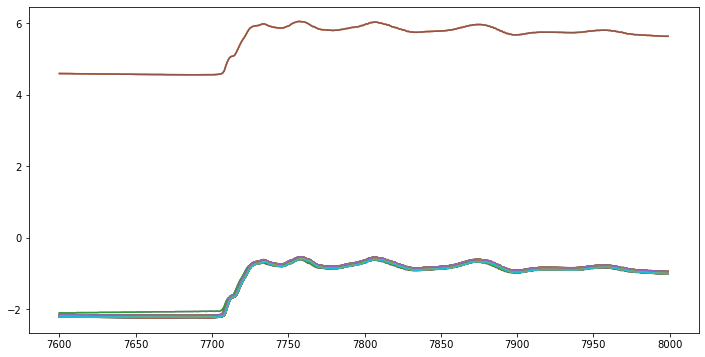

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
random_keys = np.random.randint(len(red_keys),size=100)
ax.plot(feature_grid,red_refs[random_keys].T)
plt.show()

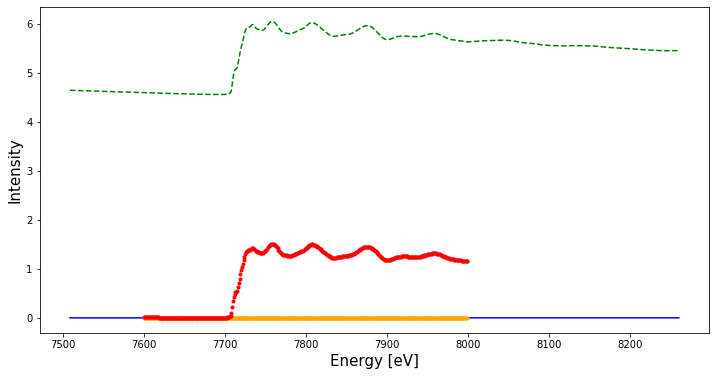

In [24]:
k = '100'
energy = raw_energies[k]
fluo = raw_fluos[k]
ref = raw_refs[k]

red_fluo = featurize(feature_grid,(energy,fluo),kind='next')
red_ref = featurize(feature_grid,(energy,ref))

# red_fluo_1 = featurize(feature_grid,(energy,fluo),kind='next')

red_fluo_c = subtract_background(red_fluo.reshape(1,-1),feature_grid,fit_range=(7650,7700))
red_ref_c = subtract_background(red_ref.reshape(1,-1),feature_grid,fit_range=(7650,7700))
fig, ax = plt.subplots(figsize=(12,6))

ax.set_ylabel('Intensity',fontsize=15)
ax.set_xlabel('Energy [eV]',fontsize=15)

ax.plot(energy,fluo,marker='',ms=4,ls='-', color='blue')
ax.plot(energy,ref,marker='',ms=4,ls='--', color='green')
# ax.plot(feature_grid,red_fluo,ls='',marker='.')
ax.plot(feature_grid,red_fluo_c.flatten(),ls='',marker='.',color='orange')
ax.plot(feature_grid,red_ref_c.flatten(),ls='',marker='.',color='red')

# ax.set_xlim([7600,8000])
plt.show()

In [43]:
red_transes.shape, red_fluos.shape, len(red_keys)

((12849, 400), (12849, 400), 12849)

In [44]:
red_trans_norm.shape, red_fluos_norm.shape, 

((12839, 400), (12839, 400))

In [53]:
keep_mask.shape, keep_mask.sum()

((12849,), 12839)

In [27]:
fnames_red[keep_mask].shape

(12839,)

In [31]:
# normalize transmission and fluorescence data concurrently
keep_mask, red_trans_norm, red_fluos_norm = \
    normalize((red_transes, red_fluos),grid=feature_grid,mean_range=(7600,7700),use_derivative=False)
fnames_norm = fnames_red[keep_mask]

# concatenate trans and fluos data vertically and subtract background
red_norm = np.vstack((red_trans_norm,red_fluos_norm))
red_norm = subtract_background(red_norm,feature_grid,fit_range=(7600,7700))
print(red_norm.shape)

red_norm_fname = [name for name,keep in zip(fnames_red,keep_mask) if keep]
red_norm_key = [key for key, keep in zip(red_keys,keep_mask) if keep]
red_norm_p = derivative(red_norm)
feature_grid_p = feature_grid[:-1]

/home/zliang/miniconda3/envs/xas/lib/python3.7/site-packages/xpython_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide
/home/zliang/miniconda3/envs/xas/lib/python3.7/site-packages/xpython_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/home/zliang/miniconda3/envs/xas/lib/python3.7/site-packages/xpython_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/home/zliang/miniconda3/envs/xas/lib/python3.7/site-packages/xpython_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


(25678, 400)


In [34]:
spec_raw = {'trans': red_transes,
            'fluos': red_fluos}
with open("e{:d}_{:d}_400grid_spec_raw.pkl".format(int(left),int(right)),'wb') as f:
    pickle.dump(spec_raw,f)

spec_norm = {'spec': red_norm, # spec data
             'key': red_norm_key, # keys in the original data
             'file': red_norm_fname, # filename associated with each data
             'derivative': red_norm_p, # spec derivative
             'feature_grid': feature_grid, # feature grid for spec data
             'feature_grid_p': feature_grid_p} # feature grid for spec derivative

with open("e{}-{}_grid400_spec_norm.pkl".format(int(left),int(right)),'wb') as f:
    pickle.dump(spec_norm,f)

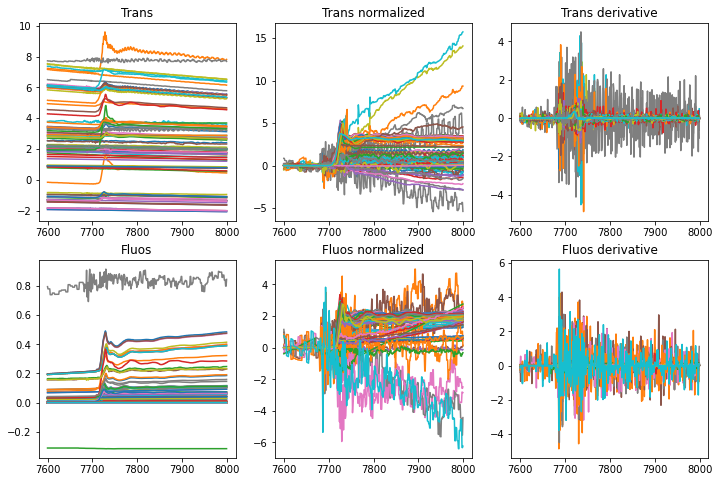

In [26]:
N_data = int(red_norm.shape[0]/2)
sel_rand = np.random.randint(N_data,size=100)

true_ = np.ones(N_data,dtype='bool')
false_ = np.zeros(N_data,dtype='bool')
select = {'trans': np.concatenate([true_, false_]),
          'fluos': np.concatenate([false_, true_])}

fig, axs = plt.subplots(2,3,figsize=(12,8))
axs[0,0].plot(feature_grid,red_transes[sel_rand].transpose())
axs[0,0].set_title('Trans')
axs[0,1].plot(feature_grid,red_norm[select['trans']][sel_rand].transpose())
axs[0,2].plot(feature_grid_p,red_norm_p[select['trans']][sel_rand].transpose())
axs[0,1].set_title('Trans normalized')
axs[0,2].set_title('Trans derivative')
axs[1,0].plot(feature_grid,red_fluos[sel_rand].transpose())
axs[1,0].set_title('Fluos')
axs[1,1].plot(feature_grid,red_norm[select['fluos']][sel_rand].transpose())
axs[1,2].plot(feature_grid_p,red_norm_p[select['fluos']][sel_rand].transpose())
axs[1,1].set_title('Fluos normalized')
axs[1,2].set_title('Fluos derivative')
plt.show()

First two components explains 96.4% of the variance


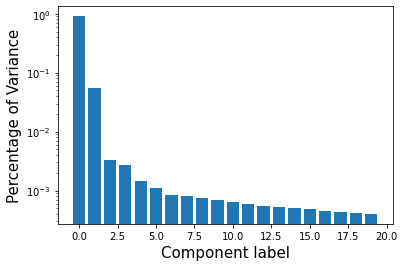

In [27]:
N_comp = 20
pca = PCA(n_components=N_comp)
pcoord = pca.fit_transform(red_norm)
print("First two components explains {:.1f}% of the variance".format(
       pca.explained_variance_ratio_[:2].sum()*100))
plt.bar(range(N_comp),pca.explained_variance_ratio_)
plt.xlabel('Component label',fontsize=15)
plt.ylabel('Percentage of Variance',fontsize=15)
plt.yscale('log')

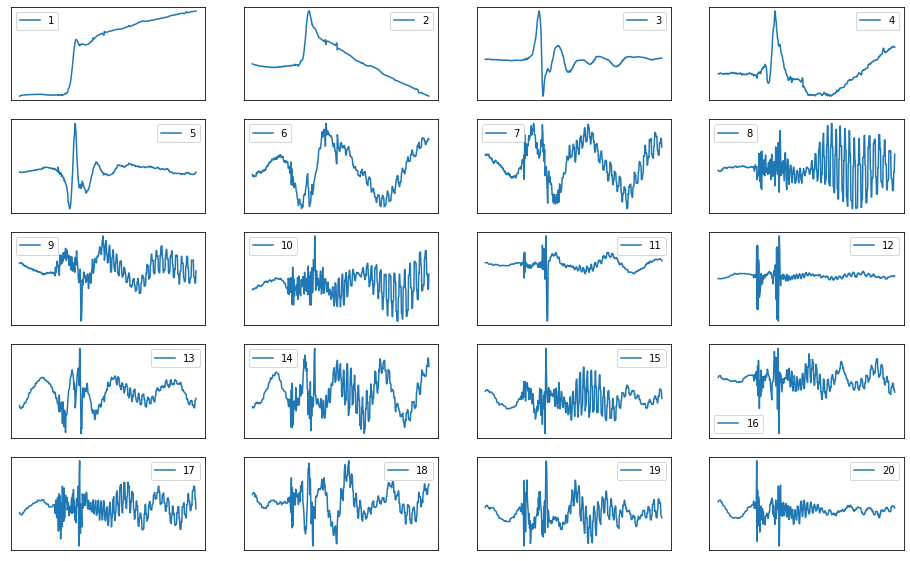

In [28]:
n_cols = 4
n_rows = int(np.ceil(N_comp/n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,2*n_rows))
for i, ax in enumerate(axs.flatten()):
    if i>= len(pca.components_): break
    ax.plot(-pca.components_[i],label=i+1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.legend()
plt.show()

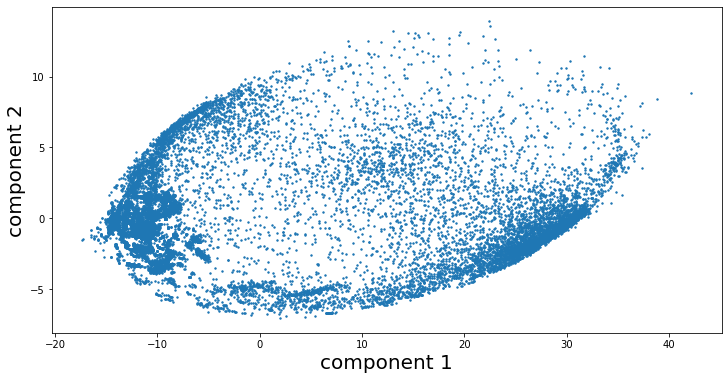

In [144]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(pcoord[:,0],pcoord[:,1],marker='o',s=2)
ax.set_xlabel('component 1',fontsize=20)
ax.set_ylabel('component 2',fontsize=20)
# ax.set_xlim([-0.1,0.1])
# ax.set_ylim([-0.1,0.1])
plt.show()

Read quality mask produced by clustering method

In [ ]:
with open("e{}-{}_grid400_mask_quality_R.pkl".format(int(norm_left),int(norm_right)),'rb') as f:
    masks = pickle.load(f)

Read quality mask predicted by NN

In [ ]:
with open("e{}-{}_grid400_mask_quality_R.pkl".format(int(norm_left),int(norm_right)),'rb') as f:
    masks = pickle.load(f)

In [3]:
feature_grid

NameError: name 'feature_grid' is not defined